# 1) Import

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import VOCSegmentation
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

# 2) Image class 정의

In [2]:
import glob
import random
import os
from torch.utils.data import Dataset
from PIL import Image

# horse2zebra
# trainA, trainB, testA, testB
class ImageDataset(Dataset):
    def __init__(self, root, transform = None, mode = 'train'):
        self.transform = transform
        self.files_A = sorted(glob.glob(os.path.join(root, '%sA' % mode) + '/*.*'))
        self.files_B = sorted(glob.glob(os.path.join(root, '%sB' % mode) + '/*.*'))
        if len(self.files_A) > len(self.files_B):
            self.files_A, self.files_B = self.files_B, self.files_A
        self.new_perm()
        assert len(self.files_A) > 0, "Make sure you downloaded the horse2zebra images!"
    
    def new_perm(self):
        self.randperm = torch.randperm(len(self.files_B))[:len(self.files_A)]

    def __getitem__(self, index):
        item_A = self.transform(Image.open(self.files_A[index % len(self.files_A)]))
        item_B = self.transform(Image.open(self.files_B[self.randperm[index]]))
        if item_A.shape[0] != 3:
            item_A = item_A.repeat(3, 1, 1)
        if item_B.shape[0] != 3:
            item_B = item_B.repeat(3, 1, 1)
        if index ==len(self) - 1:
            self.new_perm()
        # Old versions of PyTorch didn't support normalization for different-channeled images
        return (item_A - 0.5) * 2, (item_B - 0.5) * 2

    def __len__(self):
        return min(len(self.files_A), len(self.files_B))

# 3) Generator

## 3-1) Residual block

In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, input_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, input_channels, kernel_size = 3, padding = 1, padding_mode = 'reflect')
        self.conv2 = nn.Conv2d(input_channels, input_channels, kernel_size = 3, padding = 1, padding_mode = 'reflect')
        self.instancenorm = nn.InstanceNorm2d(input_channels)
        self.activation = nn.ReLU()

    def forward(self, x):
        original_x = x.clone()
        x = self.conv1(x)
        x = self.instancenorm(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.instancenorm(x)
        return original_x + x

## 3-2) Contractor block

In [4]:
class ContractingBlock(nn.Module):
    def __init__(self, input_channels, use_bn = True, kernel_size = 3, activation = 'relu'):
        super(ContractingBlock, self).__init__()
        # Build the neural network
        self.conv1 = nn.Conv2d(input_channels, input_channels * 2, kernel_size = kernel_size, padding = 1, stride = 2, padding_mode = 'reflect')
        self.activation = nn.ReLU() if activation == 'relu' else nn.LeakyReLU(0.2)
        if use_bn:
            self.instancenorm = nn.InstanceNorm2d(input_channels * 2)
        self.use_bn = use_bn

    def forward(self, x):
        x = self.conv1(x)
        if self.use_bn:
            x = self.instancenorm(x)
        x = self.activation(x)
        return x

## 3-3) Expander block

In [5]:
class ExpandingBlock(nn.Module):
    def __init__(self, input_channels, use_bn = True):
        super(ExpandingBlock, self).__init__()
        # Build the neural network
        self.conv1 = nn.ConvTranspose2d(input_channels, input_channels // 2, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
        
        if use_bn:
            self.instancenorm = nn.InstanceNorm2d(input_channels // 2)
        self.use_bn = use_bn
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        if self.use_bn:
            x = self.instancenorm(x)
        x = self.activation(x)
        return x

## 3-4) Featuremap block

In [6]:
class FeatureMapBlock(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(FeatureMapBlock, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size = 7, padding = 3, padding_mode = 'reflect')

    def forward(self, x):
        x = self.conv(x)
        return x

## 3-5) Generator definition

In [7]:
class Generator(nn.Module):
    def __init__(self, input_channels, output_channels, hidden_channels = 64):
        super(Generator, self).__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels)
        self.contract2 = ContractingBlock(hidden_channels * 2)
        res_mult = 4
        self.res0 = ResidualBlock(hidden_channels * res_mult)
        self.res1 = ResidualBlock(hidden_channels * res_mult)
        self.res2 = ResidualBlock(hidden_channels * res_mult)
        self.res3 = ResidualBlock(hidden_channels * res_mult)
        self.res4 = ResidualBlock(hidden_channels * res_mult)
        self.res5 = ResidualBlock(hidden_channels * res_mult)
        self.res6 = ResidualBlock(hidden_channels * res_mult)
        self.res7 = ResidualBlock(hidden_channels * res_mult)
        self.res8 = ResidualBlock(hidden_channels * res_mult)
        self.expand2 = ExpandingBlock(hidden_channels * 4)
        self.expand3 = ExpandingBlock(hidden_channels * 2)
        self.downfeature = FeatureMapBlock(hidden_channels, output_channels)
        self.tanh = torch.nn.Tanh()

    def forward(self, x):
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.res0(x2)
        x4 = self.res1(x3)
        x5 = self.res2(x4)
        x6 = self.res3(x5)
        x7 = self.res4(x6)
        x8 = self.res5(x7)
        x9 = self.res6(x8)
        x10 = self.res7(x9)
        x11 = self.res8(x10)
        x12 = self.expand2(x11)
        x13 = self.expand3(x12)
        xn = self.downfeature(x13)
        
        return self.tanh(xn)

# 4) Discriminator

In [8]:
class Discriminator(nn.Module):
    def __init__(self, input_channels, hidden_channels = 64):
        super(Discriminator, self).__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels, use_bn = False, kernel_size = 4, activation = 'lrelu')
        self.contract2 = ContractingBlock(hidden_channels * 2, kernel_size = 4, activation = 'lrelu')
        self.contract3 = ContractingBlock(hidden_channels * 4, kernel_size = 4, activation = 'lrelu')
        self.final = nn.Conv2d(hidden_channels * 8, 1, kernel_size = 1)

    def forward(self, x):
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)
        xn = self.final(x3)
        return xn

# 5) Initialization

## 5-1) 변수 초기화

In [9]:
import torch.nn.functional as F

adv_criterion = nn.MSELoss()
recon_criterion = nn.L1Loss()

n_epochs = 20
dim_A = 3
dim_B = 3
display_step = 200
batch_size = 1
lr = 0.0002
load_shape = 286
target_shape = 256
device = 'cpu'

## 5-2) 데이터 로딩

In [10]:
transform = transforms.Compose([
                                transforms.Resize(load_shape),
                                transforms.RandomCrop(target_shape),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor()
                                ])

import torchvision
dataset = ImageDataset("/content/drive/MyDrive/Colab Notebooks/horse2zebra", transform = transform)

## 5-3) Optimizer

In [11]:
gen_AB = Generator(dim_A, dim_B).to(device)
gen_BA = Generator(dim_B, dim_A).to(device)
gen_opt = torch.optim.Adam(list(gen_AB.parameters()) + list(gen_BA.parameters()), lr = lr, betas = (0.5, 0.999))
disc_A = Discriminator(dim_A).to(device)
disc_A_opt = torch.optim.Adam(disc_A.parameters(), lr = lr, betas = (0.5, 0.999))
disc_B = Discriminator(dim_B).to(device)
disc_B_opt = torch.optim.Adam(disc_B.parameters(), lr = lr, betas = (0.5, 0.999))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

gen_AB = gen_AB.apply(weights_init)
gen_BA = gen_BA.apply(weights_init)
disc_A = disc_A.apply(weights_init)
disc_B = disc_B.apply(weights_init)

# 6) Discriminator loss

In [12]:
def get_disc_loss(real_X, fake_X, disc_X, adv_criterion):
    disc_fake_X_hat = disc_X(fake_X.detach())  # Dh (Gzh(x))
    disc_fake_X_loss = adv_criterion(disc_fake_X_hat, torch.zeros_like(disc_fake_X_hat)) ## Ex~z[(D-0)^2]
    disc_real_X_hat = disc_X(real_X)  # Dh(y)
    disc_real_X_loss = adv_criterion(disc_real_X_hat, torch.ones_like(disc_real_X_hat))# Ey~H[(Dh(y)-1)^2]
    disc_loss = (disc_fake_X_loss + disc_real_X_loss) / 2

    return disc_loss

# 7) Generator loss

## 7-1) Adversarial loss

In [13]:
def get_gen_adversarial_loss(real_X, disc_Y, gen_XY, adv_criterion):
    fake_Y = gen_XY(real_X)  # Gzh(x)
    disc_fake_Y_hat = disc_Y(fake_Y)  # D(Gzh(x))
    adversarial_loss = adv_criterion(disc_fake_Y_hat, torch.ones_like(disc_fake_Y_hat))

    return adversarial_loss, fake_Y

## 7-2) Identity loss

In [14]:
def get_identity_loss(real_X, gen_YX, identity_criterion):
    identity_X = gen_YX(real_X)
    identity_loss = identity_criterion(identity_X, real_X)

    return identity_loss, identity_X

## 7-3) Cycle consistency loss

In [15]:
def get_cycle_consistency_loss(real_X, fake_Y, gen_YX, cycle_criterion):
    # fake_Y = gen_XY(real_X)
    cycle_X = gen_YX(fake_Y)
    cycle_loss = cycle_criterion(cycle_X, real_X)

    return cycle_loss, cycle_X

## 7-4) Total loss

In [16]:
def get_gen_loss(real_A, real_B, gen_AB, gen_BA, disc_A, disc_B,
                 adv_criterion, identity_criterion, cycle_criterion, lambda_identity = 0.1, lambda_cycle = 10):
    # Adversarial Loss
    adv_loss_BA, fake_A = get_gen_adversarial_loss(real_B, disc_A, gen_BA, adv_criterion)
    adv_loss_AB, fake_B = get_gen_adversarial_loss(real_A, disc_B, gen_AB, adv_criterion)
    gen_adversarial_loss = adv_loss_BA + adv_loss_AB

    # Identity Loss
    identity_loss_A, identity_A = get_identity_loss(real_A, gen_BA, identity_criterion)
    identity_loss_B, identity_B = get_identity_loss(real_B, gen_AB, identity_criterion)
    gen_identity_loss = identity_loss_A + identity_loss_B

    # Cycle-consistency Loss
    cycle_loss_BA, cycle_A = get_cycle_consistency_loss(real_A, fake_B, gen_BA, cycle_criterion)
    cycle_loss_AB, cycle_B = get_cycle_consistency_loss(real_B, fake_A, gen_AB, cycle_criterion)
    gen_cycle_loss = cycle_loss_BA + cycle_loss_AB

    # Total loss
    gen_loss = lambda_identity + gen_identity_loss + lambda_cycle + gen_cycle_loss + gen_adversarial_loss
    
    return gen_loss, fake_A, fake_B

# 8) Image display

In [17]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_shifted = image_tensor
    image_unflat = image_shifted.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow = 5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

# 9) training

Epoch 0: Step 0: Generator (U-Net) loss: 0.07415005683898926 Discriminator loss: 0.002863250970840454


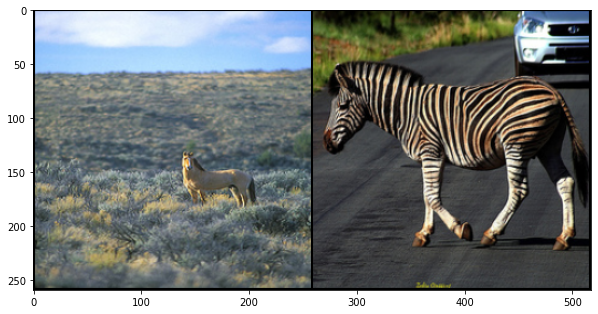

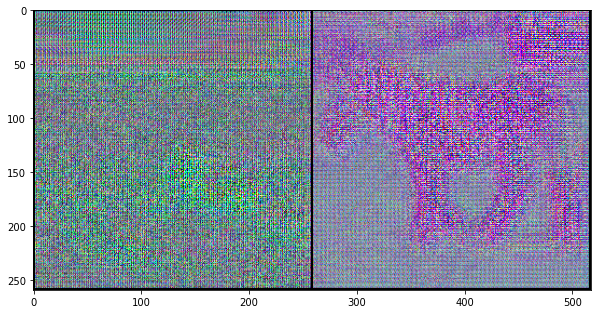

In [ ]:
from skimage import color
import numpy as np
plt.rcParams["figure.figsize"] = (10, 10)

def train(save_model = False):
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = True)
    cur_step = 0
    for epoch in range(n_epochs):
        # Dataloader returns the batches
        # for image, _ in tqdm(dataloader):
        for real_A, real_B in tqdm(dataloader):
            # image_width = image.shape[3]
            real_A = nn.functional.interpolate(real_A, size = target_shape)
            real_B = nn.functional.interpolate(real_B, size = target_shape)
            cur_batch_size = len(real_A)
            real_A = real_A.to(device)
            real_B = real_B.to(device)
          
            ### Update discriminator A ###
            disc_A_opt.zero_grad() # Zero out the gradient before backpropagation
            with torch.no_grad():
                fake_A = gen_BA(real_B)
            disc_A_loss = get_disc_loss(real_A, fake_A, disc_A, adv_criterion)
            disc_A_loss.backward(retain_graph = True)  # Update gradients
            disc_A_opt.step()  # Update optimizer

            ### Update discriminator B ###
            disc_B_opt.zero_grad() # Zero out the gradient before backpropagation
            with torch.no_grad():
                fake_B = gen_AB(real_A)
            disc_B_loss = get_disc_loss(real_B, fake_B, disc_B, adv_criterion)
            disc_B_loss.backward(retain_graph = True)  # Update gradients
            disc_B_opt.step()  # Update optimizer

            ### Update generator ###
            gen_opt.zero_grad()
            gen_loss, fake_A, fake_B = get_gen_loss(real_A, real_B, gen_AB, gen_BA, disc_A, disc_B, adv_criterion, recon_criterion, recon_criterion)
            gen_loss.backward()  # Update gradients
            gen_opt.step()  # Update optimizer

            # Keep track of the average discriminator loss
            mean_discriminator_loss += disc_A_loss.item() / display_step
            # Keep track of the average generator loss
            mean_generator_loss += gen_loss.item() / display_step

            ### Visualization code ###
            if cur_step % display_step == 0:
                print(f"Epoch {epoch}: Step {cur_step}: Generator (U-Net) loss: {mean_generator_loss} Discriminator loss: {mean_discriminator_loss}")
                show_tensor_images(torch.cat([real_A, real_B]), size = (dim_A, target_shape, target_shape))
                show_tensor_images(torch.cat([fake_B, fake_A]), size = (dim_B, target_shape, target_shape))
                mean_generator_loss = 0
                mean_discriminator_loss = 0
                # You can change save_model to True if you'd like to save the model
                if save_model:
                    torch.save({
                        'gen_AB': gen_AB.state_dict(),
                        'gen_BA': gen_BA.state_dict(),
                        'gen_opt': gen_opt.state_dict(),
                        'disc_A': disc_A.state_dict(),
                        'disc_A_opt': disc_A_opt.state_dict(),
                        'disc_B': disc_B.state_dict(),
                        'disc_B_opt': disc_B_opt.state_dict()
                    }, f"cycleGAN_{cur_step}.pth")
            cur_step += 1
train()